<h1>libraries</h1>


In [1]:
import os 
from PIL import Image
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

Using TensorFlow backend.


<h1>mapping hand gestures with numerical values</h1>

In [2]:
def lookup_table():
    
   dict =  {'01_palm': 0,
            '02_l': 1,
            '03_fist': 2,
            '04_fist_moved': 3,
            '05_thumb': 4,
            '06_index': 5,
            '07_ok': 6,
            '08_palm_moved': 7,
            '09_c': 8,
            '10_down': 9}
   
   return dict


<h1>Directory selection based on OS</h1>

In [5]:
if os.name == "nt":
    dir = os.getcwd() + "\\downloads\\leapGestRecog"
else:
    dir = os.getcwd() + "/downloads/leapGestRecog"

<h1>extracting images into x_data and its corresponding mapped numerical data into y_data</h1>

In [6]:
x_data = []
y_data = []
for folder in os.listdir(dir):   
    if not folder.startswith("."):    
        for subfolder in os.listdir(dir + "/" + folder):
            if not subfolder.startswith("."):
                for gesture in os.listdir(dir + "/" + folder + "/" + subfolder):
                    img = Image.open(dir + "/" + folder + "/" + subfolder + "/" + gesture)
                    img = img.resize((320, 120))
                    _,thresh = cv2.threshold(np.array(img),127,255,cv2.ADAPTIVE_THRESH_MEAN_C)
                    x_data.append(thresh)
                    y_data.append(lookup_table()[subfolder])

In [9]:
y_data[0]

4

In [3]:
reverse_dict = { lookup_table()[k]:k for k in lookup_table()}


In [6]:
ret,thresh1 = cv2.threshold(x_data[0],127,255,cv2.ADAPTIVE_THRESH_MEAN_C)
cv2.imshow("img",thresh1)
cv2.waitKey(0)

113

In [7]:
print(reverse_dict)
cv2.imshow("i",x_data[0])
cv2.waitKey(0)

{0: '01_palm', 1: '02_l', 2: '03_fist', 3: '04_fist_moved', 4: '05_thumb', 5: '06_index', 6: '07_ok', 7: '08_palm_moved', 8: '09_c', 9: '10_down'}


113

<h1>plot for 10 different hand gesture</h1>

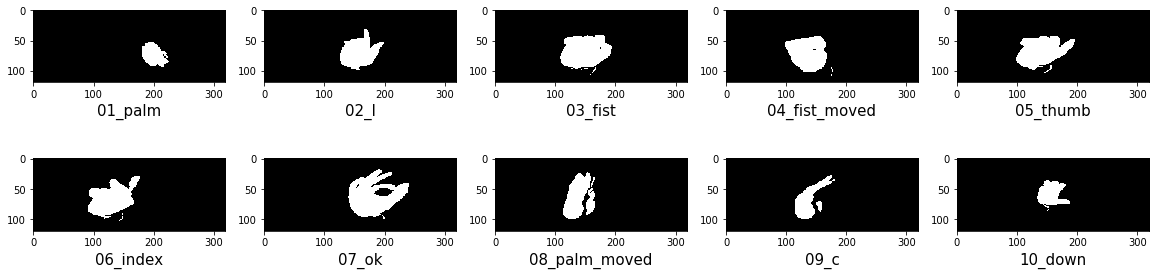

In [8]:
fig = plt.figure(figsize=(20,5))
for i in range(0,10):
    fig.add_subplot(2,5,i+1)
    plt.imshow(x_data[i*200], cmap="gray")
    plt.xlabel(reverse_dict[y_data[i*200]],  fontsize=15)

<h1>reshaping the array to 1 indicates b/w channels for keras

to_categorical changes y to one hot encoded version</h1>

In [9]:
X = np.array(x_data, dtype="float32") / 255
y = np.array(y_data)

X = X.reshape(X.shape[0],X.shape[1],X.shape[2], 1)
y = to_categorical(y)

<h1>splitting dataset for training, testing and evaluation</h1>

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101) 
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

<h1>convolution neural networks for training the model</h1>

In [11]:
model = Sequential()
model.add(Conv2D(32, (2,2), strides=(2,2), activation="relu", input_shape=(120,320,1)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(128, (3,3), activation="relu"))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation="softmax"))



In [12]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2, batch_size=64, verbose=1)

Train on 14000 samples, validate on 3000 samples
Epoch 1/2
14000/14000 [==============================] - 89s 6ms/step - loss: 0.2426 - accuracy: 0.9224 - val_loss: 0.0338 - val_accuracy: 0.9923
Epoch 2/2
14000/14000 [==============================] - 90s 6ms/step - loss: 0.0110 - accuracy: 0.9972 - val_loss: 0.0133 - val_accuracy: 0.9977


In [13]:
model.save('trained.h5')

In [5]:
model = load_model("trained.h5")

In [15]:
_, acc = model.evaluate(x_test,y_test, verbose = 1)
print("accuracy: ", round(acc * 100,2), "%")

3000/3000 [==============================] - 4s 1ms/step
accuracy:  99.7 %


<h1>recognition</h1>

In [7]:
videocapture = cv2.VideoCapture(0)
while True:
    
    _, frame = videocapture.read()
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
    color = frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    frame = cv2.resize(frame, (320, 120), interpolation = cv2.INTER_AREA)
    frame = cv2.GaussianBlur(frame, (5, 5), 0)
    _,thresh = cv2.threshold(frame,140,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    new = thresh[0:500, 0:600]
    #cv2.imshow("j",new)
    
    
    frame = np.array(new, dtype="float32") 
    frame = frame.reshape(1,frame.shape[0],frame.shape[1], 1)
    text = np.argmax(model.predict(frame))
    print(text)
    im = cv2.putText(color, "_".join(reverse_dict[text].split("_")[1:]) ,(304,662), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow("frame1",new)
    cv2.imshow("frame",im)
    



videocapture.release()
cv2.destroyAllWindows()

4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
9
9
9
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
9
9
9
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
9
9
1
1
9
1
1
1
1
1
1
9
1
1
9
1
9
1
1
1
1
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
1
2
1
9
9
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


<h1>custom dataset generation</h1>


In [1]:
import cv2 
import os 

camera = cv2.VideoCapture(0)



dir_peace = os.getcwd() + "/custom dataset/peace/"
dir_fist = os.getcwd() + "/custom dataset/fist/"

if not os.path.exists(os.getcwd() + "/custom dataset"):
    os.makedirs(os.getcwd() + "/custom dataset")

if not os.path.exists(dir_peace):
    os.makedirs(dir_peace)
    
    
if not os.path.exists(dir_fist):
    os.makedirs(dir_fist)
    

hand_classifier = cv2.CascadeClassifier("Haarcascades/Hand_haar_cascade.xml")


count = 0
while True:
    
    _,frame = camera.read()
    
    color = frame
    if cv2.waitKey(25) & 0xFF == ord('q'):
        camera.release()
        cv2.destroyAllWindows()
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    _,thresh = cv2.threshold(gray,127,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
    hands = hand_classifier.detectMultiScale(thresh, 1.1, 5)

        
    for (x, y, w, h) in hands:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        x = x - 100
        y = y - 100
        w = w + 100
        h = h + 100
        
        new = thresh[y:y+h, x:x+w]

        try:
            # frame = cv2.resize(new, (320,120), interpolation = cv2.INTER_LINEAR)
            # frame = np.array(frame, dtype="float32") 
            # frame = frame.reshape(1,frame.shape[0],frame.shape[1], 1)
            # text = np.argmax(model.predict(frame))
            # im = cv2.putText(color, "_".join(reverse_dict[text].split("_")[1:]) ,(304,662), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2, cv2.LINE_AA)

            
            if cv2.waitKey(25) & 0xFF == ord('p'):
                count += 1
                cv2.imwrite(dir_peace + "%s.png" %(count) , new)
                
                
        
            cv2.imshow("new",new)
        except:
            pass
        
    
    low_size = cv2.resize(color, (200,200) , interpolation = cv2.INTER_LINEAR)
    #scaled = cv2.resize(low_size, None, fx = 4, fy = 4, interpolation = cv2.INTER_LINEAR)
    cv2.imshow("thresh",low_size)
    

camera.release()
cv2.destroyAllWindows()